---
---
# Introducción a la optimización lineal

En esta última lección, nos desviaremos de las técnicas que emplean métodos estándar de aprendizaje automático para centrarnos en un área que, si bien fundamentalmente es algo distinta, es tan útil y aplicable como todo lo visto anteriormente. Concretamente, la optimización lineal es, como su nombre indica, el área de estudio de problemas de maximización (resp. minimización) de funciones donde, tanto la propia función como las restricciones de dominio, son lineales.

Comenzaremos inicialmente por introducir algunos conceptos de tipo geométrico, que nos serán de ayuda para entender el contexto. Para lectores con conocimientos matemáticos sólidos, recomendamos seguir los contenidos de este [curso abierto del MIT](https://ocw.mit.edu/courses/6-251j-introduction-to-mathematical-programming-fall-2009/pages/lecture-notes/).

---
## Nociones geométricas: Convexidad

El primer concepto de obligada introducción es el de convexidad, tanto de un conjunto como de una función. Diremos que un conjunto es convexo cuando, para cualesquiera dos puntos del mismo, el segmento que los une está contenido dentro del conjunto.

> Ejercicio: ¿Sabrías decir cuáles de éstos conjuntos son convexos?

![](http://d2l.ai/_images/pacman.svg)

En términos formales, diríamos que un conjunto $C\subset\mathbb{R}^n$ del espacio euclídeo es convexo cuando, para cualesquiera puntos $x,y\in C$ y número $\lambda \in (0,1)$, el punto $\lambda x+(1-\lambda)y$ también está en $C$. Nótese que, de la forma anterior, se puede expresar cualquier punto del interior del segmento que une a los puntos $x$ e $y$. 

Una propiedad muy interesante que usaremos relacionada con este concepto es el hecho de que, cuando disponemos de dos conjuntos convexos, su **intersección** también lo es:

![](http://d2l.ai/_images/convex-intersect.svg)

De forma similar, diremos que una función real $f:C\rightarrow\mathbb{R}$ es convexa cuando

$$\lambda f(x) + (1-\lambda) f(y) \geq f(\lambda x + (1-\lambda) y),$$

para todos $x,y\in C$, $\lambda\in(0,1)$. Evidentemente, la definición de función convexa exige que su dominio $C$ también lo sea. Veamos ahora de forma intuitiva qué nos quiere decir esta definición:

> Ejercicio: ¿Sabrías decir qué funciones son convexas?

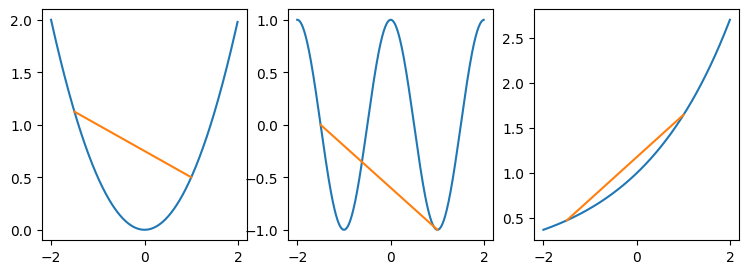

In [1]:
# Librerías
import numpy as np
import matplotlib.pyplot as plt

# Definimos funciones
f = lambda x: 0.5 * x**2
g = lambda x: np.cos(np.pi * x)
h = lambda x: np.exp(0.5 * x)

# Dibujamos sus gráficas
x, segment = np.arange(-2, 2, 0.01), np.array([-1.5, 1])
_, axes = plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    ax.plot(x, func(x), segment, func(segment))
plt.show()

En términos de cálculo, la convexidad de una función se puede estudiar de manera cómoda a partir del carácter semidefinido positivo de la matriz hessiana en todo el dominio. La razón por la que, sin duda, la convexidad es una propiedad deseable en nuestro ámbito, es debido a que los máximos (resp. mínimos) locales de funciones convexas son, de hecho, globales. Esto tiene aplicaciones en los siguientes ámbitos:
* Problemas generales de optimización convexa, a partir de la desigualdad de Jensen.
* Términos añadidos a funciones de pérdida en determinados contextos del *machine learning* para asegurar la convexidad en una cierta región.
* Problemas de naturaleza física variacional donde intervienen herramientas como los **multiplicadores de Lagrange**.

---

## Nociones geométricas: Linealidad

Naturalmente que las funciones lineales son, en particular, convexas, por lo que todo lo introducido anteriormente es aplicable. Llegados a este punto, veamos qué interpretación geométrica tienen las funciones y/o restricciones lineales dentro del contexto de un problema. Cuando escribimos una restricción lineal, por ejemplo que la suma de dos números sea menor o igual que uno, tiene el siguiente aspecto:

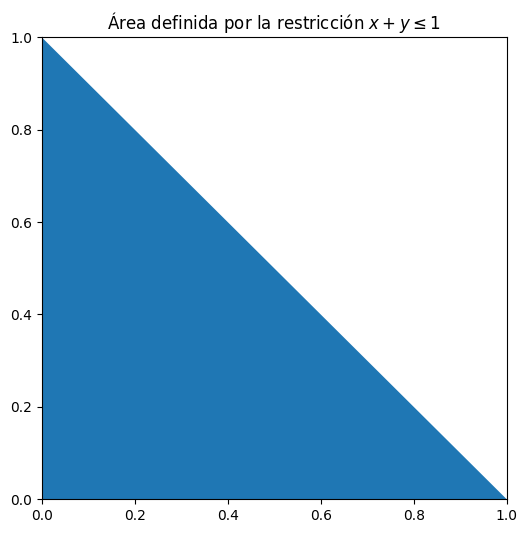

In [28]:
# Definimos el dominio
x = np.arange(-1, 1.01, 0.05)
# Definimos la función de referencia
y1 = lambda x: -x+1
# Definimos una función auxiliar para poder realizar el dibujo
y2 = lambda x: x-25

# Mapeamos el dibujo
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.fill_between(x, y1(x), y2(x))
ax.set_title('Área definida por la restricción $x+y\leq 1$')
plt.show()

El conjunto descrito por los puntos que cumplen la restricción lineal se conoce como **semiespacio**, que es ciertamente convexo aunque no acotado. Es por ello que, normalmente, se trabaja con múltiples restricciones, dando lugar a conjuntos formados por las intersecciones de estos semiespacios, que sí son acotados, como en el siguiente ejemplo tomado de la documentación de `scipy`:

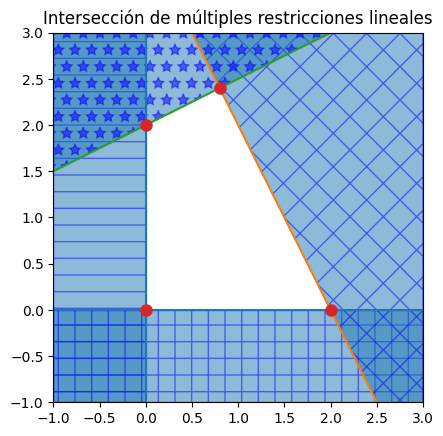

In [15]:
from scipy.spatial import HalfspaceIntersection
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
xlim, ylim = (-1, 3), (-1, 3)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
x = np.linspace(-1, 3, 100)
symbols = ['-', '+', 'x', '*']
signs = [0, 0, -1, -1]
fmt = {"color": None, "edgecolor": "b", "alpha": 0.5}
halfspaces = np.array([[-1, 0., 0.],
                       [0., -1., 0.],
                       [2., 1., -4.],
                       [-0.5, 1., -2.]])
feasible_point = np.array([0.5, 0.5])
hs = HalfspaceIntersection(halfspaces, feasible_point)
for h, sym, sign in zip(halfspaces, symbols, signs):
    hlist = h.tolist()
    fmt["hatch"] = sym
    if h[1]== 0:
        ax.axvline(-h[2]/h[0], label='{}x+{}y+{}=0'.format(*hlist))
        xi = np.linspace(xlim[sign], -h[2]/h[0], 100)
        ax.fill_between(xi, ylim[0], ylim[1], **fmt)
    else:
        ax.plot(x, (-h[2]-h[0]*x)/h[1], label='{}x+{}y+{}=0'.format(*hlist))
        ax.fill_between(x, (-h[2]-h[0]*x)/h[1], ylim[sign], **fmt)
x, y = zip(*hs.intersections)
ax.plot(x, y, 'o', markersize=8)
ax.set_title("Intersección de múltiples restricciones lineales")
plt.show()

En estas circunstancias, la optimización de funciones lineales es fácilmente resoluble mediante el conocido como **algoritmo del simplex**, que se basa en el hecho de que la solución de un problema de optimización lineal con restricciones lineales se encuentra en uno de los **vértices** del dominio, que arribe hemos señalado de color rojo.

A continuación, vamos a desglosar un excelente caso de uso de [Maxime Labonne](https://mlabonne.github.io/blog/).

---
## Caso de uso: Optimización lineal

Para la ejecución de esta parte del cuaderno, recomendamos al alumno emplear [Google Colab](https://colab.research.google.com/?hl=es).

Supongamos que estamos comandando un ejército de espadachines, arqueros y jinetes, disponiendo de una serie de recursos materiales para su manutención y remuneración, y queremos sacar el máximo partido a la capacidad o fuerza de nuestra tropa. Para ello, somos provistos de la siguiente relación entre milicia, recursos requeridos y fuerza:

<br/>

| Unidad | 🌾 Comida | 🪵 Madera | 🥇 Oro | 💪 Fuerza |
| :--- | :---: | :---: | :---: | :---: |
| 🗡️ Espadachín | 60 | 20 | 0 | 70 |
| 🏹 Arquero | 80 | 10 | 40 | 95 |
| 🐎 Jinetes | 140 | 0 |100 | 230 |

<br/>

En primer lugar, instalaremos las dependencias necesarias para tener acceso a algoritmos de optimización que nos permitan resolverlo. Existen múltiples apra tal fin, pero debido a su flexibilidad, facilidad de uso, extensión y optimización interna, escogeremos [Google OR-Tools](https://developers.google.com/optimization). 

In [16]:
!python -m pip install --upgrade --user -q ortools

ERROR: Can not perform a '--user' install. User site-packages are not visible in this virtualenv.

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from ortools.linear_solver import pywraplp

# Create a solver using the GLOP backend
solver = pywraplp.Solver('Maximize army power', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

Una vez hemos instanciado el `solver`, es momento de definir las variables de nuestro problema, que son las distintas unidades que formarán parte de las tropas. OR-Tools acepta tres tipos de variables:

* `NumVar` para continuas.
* `IntVar` para enteros.
* `BoolVar` para dicotómicas.

Puesto que no tenemos realmente una cota superior, y precisamos de números enteros, instanciamos nuestras variables como sigue:

In [18]:
swordsmen = solver.IntVar(0, solver.infinity(), 'espadachines')
bowmen = solver.IntVar(0, solver.infinity(), 'arqueros')
horsemen = solver.IntVar(0, solver.infinity(), 'jinetes')

Seguidamente, nos toca definir el conjunto de restricciones que aplican en nuestro caso. Dado que los recursos naturales son limitados, no podremos tener e nla práctica un número infinito de efectivos; de hecho, se nos proporciona esta lista actualizada de recursos disponibles:

<br/>

| 🌾 Comida | 🪵 Madera | 🥇 Oro |
| :---: | :---: | :---: |
| 1200 | 800 | 600 | 

<br/>

Consecuentemente, aparecen las siguientes restricciones para cada recurso:

In [19]:
solver.Add(swordsmen*60 + bowmen*80 + horsemen*140 <= 1200) # Comida
solver.Add(swordsmen*20 + bowmen*10 <= 800)                 # Madera
solver.Add(bowmen*40 + horsemen*100 <= 600)                 # Oro

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x00000203365FFA20> >

Finalmente, nuestra pretensión es tener la tropa más efectiva posible, lo cual es equivalente a **maximizar** la fuerza de la misma. Así pues, nuestra función objetivo será:

In [20]:
solver.Maximize(swordsmen*70 + bowmen*95 + horsemen*230)

Ya estamos listos para resolver el problema original:

In [21]:
status = solver.Solve()

# Si encontró solución óptima, muestra los resultados
if status == pywraplp.Solver.OPTIMAL:
  print('================= Solución =================')
  print(f'Resuelto en {solver.wall_time():.2f} milisegundos con {solver.iterations()} iteraciones')
  print()
  print(f'Fuerza óptima = {solver.Objective().Value()} 💪')
  print('Tropa:')
  print(f' - 🗡️ Espadachines = {swordsmen.solution_value()}')
  print(f' - 🏹 Arqueros = {bowmen.solution_value()}')
  print(f' - 🐎 Jinetes = {horsemen.solution_value()}')
else:
  print('No se encontró una solución óptima.')

================= Solución =================
Resuelto en 374.00 milisegundos con 2 iteraciones

Fuerza óptima = 1800.0 💪
Tropa:
 - 🗡️ Espadachines = 6.0000000000000036
 - 🏹 Arqueros = 0.0
 - 🐎 Jinetes = 5.999999999999999
